In [1]:
# Mount Drive into Google CoLab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Console Window
# !pip install colab-xterm
# %load_ext colabxterm
# %xterm

In [3]:
# Install from PyPI. if you already have OmniSafe installed, please ignore the code in this cell.
!pip install omnisafe

In [4]:
%%bash
apt-get install libosmesa6-dev
apt-get install python3-opengl

Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  libdrm-dev libgl-dev libglx-dev libosmesa6 libpciaccess-dev mesa-common-dev
The following NEW packages will be installed:
  libdrm-dev libgl-dev libglx-dev libosmesa6 libosmesa6-dev libpciaccess-dev mesa-common-dev
0 upgraded, 7 newly installed, 0 to remove and 45 not upgraded.
Need to get 5,768 kB of archives.
After this operation, 18.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libpciaccess-dev amd64 0.16-3 [21.9 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libdrm-dev amd64 2.4.113-2~ubuntu0.22.04.1 [292 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libglx-dev amd64 1.4.0-1 [14.1 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/main amd64 libgl-dev amd64 1.4.0-1 [101 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 mesa-common-dev amd64 23.

In [5]:
%env MUJOCO_GL=osmesa
%env PYOPENGL_PLATFORM=osmesa

env: MUJOCO_GL=osmesa
env: PYOPENGL_PLATFORM=osmesa


In [9]:
import torch
import warnings

# # Set the device.
print(torch.cuda.device_count())
avaliable_gpus = [num for num in range(torch.cuda.device_count())]
gpu_id = [0]
# gpu_id = None

if set(gpu_id) > set(avaliable_gpus):
    warnings.warn('The GPU ID is not available, use CPU instead.')
    gpu_id = None
else:
    gpu_id = gpu_id

print("GPU ID:", gpu_id)

0
GPU ID: None


<ipython-input-9-cd6660d43457>:11: UserWarning: The GPU ID is not available, use CPU instead.
  warnings.warn('The GPU ID is not available, use CPU instead.')


In [15]:
import os
import sys
import warnings

import torch

import omnisafe
from omnisafe.common.experiment_grid import ExperimentGrid
from omnisafe.typing import NamedTuple, Tuple


def train(
    exp_id: str, algo: str, env_id: str, custom_cfgs: NamedTuple
) -> Tuple[float, float, float]:
    """Train a policy from exp-x config with OmniSafe.

    Args:
        exp_id (str): Experiment ID.
        algo (str): Algorithm to train.
        env_id (str): The name of test environment.
        custom_cfgs (NamedTuple): Custom configurations.
        num_threads (int, optional): Number of threads. Defaults to 6.
    """
    terminal_log_name = 'terminal.log'
    error_log_name = 'error.log'
    if 'seed' in custom_cfgs:
        terminal_log_name = f'seed{custom_cfgs["seed"]}_{terminal_log_name}'
        error_log_name = f'seed{custom_cfgs["seed"]}_{error_log_name}'
    sys.stdout = sys.__stdout__
    sys.stderr = sys.__stderr__
    print(f'exp-x: {exp_id} is training...')
    if not os.path.exists(custom_cfgs['logger_cfgs']['log_dir']):
        os.makedirs(custom_cfgs['logger_cfgs']['log_dir'], exist_ok=True)
    # pylint: disable-next=consider-using-with
    sys.stdout = open(
        os.path.join(f'{custom_cfgs["logger_cfgs"]["log_dir"]}', terminal_log_name),
        'w',
        encoding='utf-8',
    )
    # pylint: disable-next=consider-using-with
    sys.stderr = open(
        os.path.join(f'{custom_cfgs["logger_cfgs"]["log_dir"]}', error_log_name),
        'w',
        encoding='utf-8',
    )
    agent = omnisafe.Agent(algo, env_id, custom_cfgs=custom_cfgs)
    reward, cost, ep_len = agent.learn()
    return reward, cost, ep_len

In [16]:
def set_experiment_grid(exp_name):
    experiment_grid = ExperimentGrid(exp_name)
    return experiment_grid

version, run = 3, "AntVelocity2"
run_id = str(version) + "." + str(run)
exp_name = "OmniSafe-Run_{}".format(run_id)

eg = set_experiment_grid(exp_name)

# Set the algorithms.
algorithms = ['PolicyGradient', 'TRPO', 'PPO', 'CPO', 'PCPO']
# algorithms = ['TRPO']

# Set the environments.
# test_envs = ['SafetyPointGoal2-v0']
# test_envs = ['SafetyCarCircle2-v0']
test_envs = ['SafetyAntVelocity-v1']
epochs = 20
steps_per_epoch = 1024
total_steps = epochs * steps_per_epoch

eg.add('env_id', test_envs)
eg.add('algo', algorithms)
eg.add('logger_cfgs:use_wandb', [False])
eg.add('train_cfgs:vector_env_nums', [1])
eg.add('train_cfgs:torch_threads', [1])
eg.add('train_cfgs:total_steps', [total_steps])
eg.add('algo_cfgs:steps_per_epoch', [steps_per_epoch])
eg.add('seed', [0])


In [17]:
pool_count = len(algorithms) * len(test_envs)
if gpu_id is None:
    print("Running Experiment {} on CPU".format(exp_name))
    eg.run(train, num_pool=pool_count)
else:
    print("Running Experiment {} on GPU ID: {}".format(exp_name, gpu_id))
    eg.run(train, num_pool=pool_count, gpu_id=gpu_id)

Running Experiment OmniSafe-Run_3.AntVelocity2 on CPU


Save with config of experiment grid in grid_config.json

ExperimentGrid [OmniSafe-Run_3.AntVelocity2] runs over parameters:

 env_id                                  

[env] 

	"SafetyAntVelocity-v1"



 algo                                    

[alg] 

	"PolicyGradient"
	"TRPO"
	"PPO"
	"CPO"
	"PCPO"



 logger_cfgs:use_wandb                   

[log-use] 

	false



 train_cfgs:vector_env_nums              

[tra-vec] 

	1



 train_cfgs:torch_threads                

[tra-tor] 

	1



 train_cfgs:total_steps                  

[tra-tot] 

	20480



 algo_cfgs:steps_per_epoch               

[alg-ste] 

	1024



 seed                                    

[see] 

	0

 Variants, counting seeds:               5
 Variants, not counting seeds:           5

value {'seed': 0, 'algo_cfgs': {'steps_per_epoch': 1024}, 'train_cfgs': {'total_steps': 20480, 'torch_threads': 1, 'vector_env_nums': 1}, 'logger_cfgs': {'use_wandb': False}, 'algo': 'PolicyGradient', 'env_id': 'SafetyAntVelocity-v1'} key algo
value {'seed': 0, 'algo_cfgs': {'steps_per_epoch': 1024}, 'train_cfgs': {'total_steps': 20480, 'torch_threads': 1, 'vector_env_nums': 1}, 'logger_cfgs': {'use_wandb': False}, 'algo': 'TRPO', 'env_id': 'SafetyAntVelocity-v1'} key algo
value {'seed': 0, 'algo_cfgs': {'steps_per_epoch': 1024}, 'train_cfgs': {'total_steps': 20480, 'torch_threads': 1, 'vector_env_nums': 1}, 'logger_cfgs': {'use_wandb': False}, 'algo': 'PPO', 'env_id': 'SafetyAntVelocity-v1'} key algo
value {'seed': 0, 'algo_cfgs': {'steps_per_epoch': 1024}, 'train_cfgs': {'total_steps': 20480, 'torch_threads': 1, 'vector_env_nums': 1}, 'logger_cfgs': {'use_wandb': False}, 'algo': 'CPO', 

Preparing to run the following experiments...


OmniSafe-Run_3.AntVelocity2_algcpo
OmniSafe-Run_3.AntVelocity2_algpcpo
OmniSafe-Run_3.AntVelocity2_algpolicygradient
OmniSafe-Run_3.AntVelocity2_algppo
OmniSafe-Run_3.AntVelocity2_algtrpo

current_config {'seed': 0, 'algo_cfgs': {'steps_per_epoch': 1024}, 'train_cfgs': {'total_steps': 20480, 'torch_threads': 1, 'vector_env_nums': 1}, 'logger_cfgs': {'use_wandb': False}, 'algo': 'PolicyGradient', 'env_id': 'SafetyAntVelocity-v1'}
current_config {'seed': 0, 'algo_cfgs': {'steps_per_epoch': 1024}, 'train_cfgs': {'total_steps': 20480, 'torch_threads': 1, 'vector_env_nums': 1}, 'logger_cfgs': {'use_wandb': False}, 'algo': 'TRPO', 'env_id': 'SafetyAntVelocity-v1'}
current_config {'seed': 0, 'algo_cfgs': {'steps_per_epoch': 1024}, 'train_cfgs': {'total_steps': 20480, 'torch_threads': 1, 'vector_env_nums': 1}, 'logger_cfgs': {'use_wandb': False}, 'algo': 'PPO', 'env_id': 'SafetyAntVelocity-v1'}
current_config {'seed': 0, 'algo_cfgs': {'steps_per_epoch': 1024}, 'train_cfgs': {'total_steps': 20

Plotting from...

./exp-x/OmniSafe-Run_3.AntVelocity2/SafetyAntVelocity-v1---a077f30f65e4087a51c36eda1152a1325a88cb9effcfd87a0273405ebd48a731
./exp-x/OmniSafe-Run_3.AntVelocity2/SafetyAntVelocity-v1---394d6bee586e4f4fabcbd7fb6e1571ff961aa4444669d9b9ef5ad93ecf9ed886
./exp-x/OmniSafe-Run_3.AntVelocity2/SafetyAntVelocity-v1---d4c7d221532a0acda0270c543172ca1a6e682397be14b10d767de3a3157f9b0f
./exp-x/OmniSafe-Run_3.AntVelocity2/SafetyAntVelocity-v1---793728822ce16a40cfef8e20996189b73b3080e8d7dfcb558b11ba68500e4e3a
./exp-x/OmniSafe-Run_3.AntVelocity2/SafetyAntVelocity-v1---fae79586449e3f430a654722669a22b11fe9a68b91579f1a2d518aea79970b40



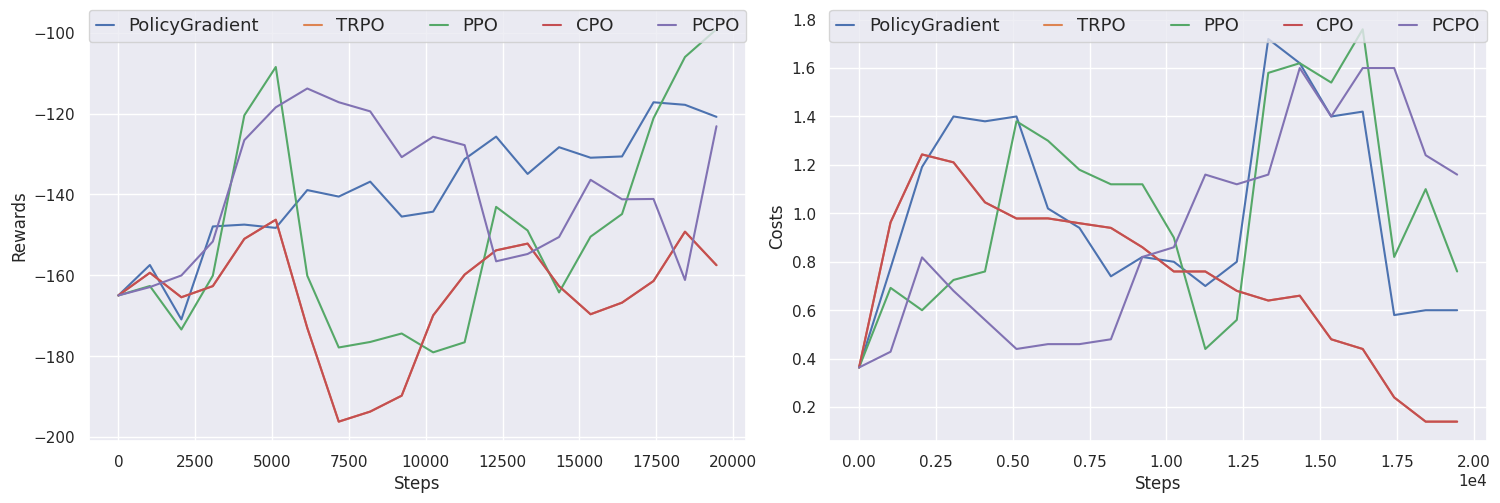

In [18]:
eg.analyze(parameter='algo', values=algorithms, compare_num=None, cost_limit=None)

In [19]:
eg.render(num_episodes=1, render_mode='rgb_array', width=256, height=256)
eg.evaluate(num_episodes=1)


##################################################

Saving the replay video to ./exp-x/OmniSafe-Run_3.AntVelocity2/SafetyAntVelocity-v1---fae79586449e3f430a654722669a22b11fe9a68b91579f1a2d518aea79970b40/PCPO-{SafetyAntVelocity-v1}/seed-000-2024-04-26-12-38-09/video/epoch-0,
 and the result to ./exp-x/OmniSafe-Run_3.AntVelocity2/SafetyAntVelocity-v1---fae79586449e3f430a654722669a22b11fe9a68b91579f1a2d518aea79970b40/PCPO-{SafetyAntVelocity-v1}/seed-000-2024-04-26-12-38-09/video/epoch-0/result.txt.

##################################################

Moviepy - Building video /content/exp-x/OmniSafe-Run_3.AntVelocity2/SafetyAntVelocity-v1---fae79586449e3f430a654722669a22b11fe9a68b91579f1a2d518aea79970b40/PCPO-{SafetyAntVelocity-v1}/seed-000-2024-04-26-12-38-09/video/epoch-0/eval-episode-0.mp4.
Moviepy - Writing video /content/exp-x/OmniSafe-Run_3.AntVelocity2/SafetyAntVelocity-v1---fae79586449e3f430a654722669a22b11fe9a68b91579f1a2d518aea79970b40/PCPO-{SafetyAntVelocity-v1}/seed-000-2024-0

Moviepy - Done !
Moviepy - video ready /content/exp-x/OmniSafe-Run_3.AntVelocity2/SafetyAntVelocity-v1---fae79586449e3f430a654722669a22b11fe9a68b91579f1a2d518aea79970b40/PCPO-{SafetyAntVelocity-v1}/seed-000-2024-04-26-12-38-09/video/epoch-0/eval-episode-0.mp4

##################################################


##################################################

Saving the replay video to ./exp-x/OmniSafe-Run_3.AntVelocity2/SafetyAntVelocity-v1---d4c7d221532a0acda0270c543172ca1a6e682397be14b10d767de3a3157f9b0f/PPO-{SafetyAntVelocity-v1}/seed-000-2024-04-26-12-38-09/video/epoch-0,
 and the result to ./exp-x/OmniSafe-Run_3.AntVelocity2/SafetyAntVelocity-v1---d4c7d221532a0acda0270c543172ca1a6e682397be14b10d767de3a3157f9b0f/PPO-{SafetyAntVelocity-v1}/seed-000-2024-04-26-12-38-09/video/epoch-0/result.txt.

##################################################

Moviepy - Building video /content/exp-x/OmniSafe-Run_3.AntVelocity2/SafetyAntVelocity-v1---d4c7d221532a0acda0270c543172ca1a6e682397be1

Moviepy - Done !
Moviepy - video ready /content/exp-x/OmniSafe-Run_3.AntVelocity2/SafetyAntVelocity-v1---d4c7d221532a0acda0270c543172ca1a6e682397be14b10d767de3a3157f9b0f/PPO-{SafetyAntVelocity-v1}/seed-000-2024-04-26-12-38-09/video/epoch-0/eval-episode-0.mp4

##################################################


##################################################

Saving the replay video to ./exp-x/OmniSafe-Run_3.AntVelocity2/SafetyAntVelocity-v1---a077f30f65e4087a51c36eda1152a1325a88cb9effcfd87a0273405ebd48a731/PolicyGradient-{SafetyAntVelocity-v1}/seed-000-2024-04-26-12-38-09/video/epoch-0,
 and the result to ./exp-x/OmniSafe-Run_3.AntVelocity2/SafetyAntVelocity-v1---a077f30f65e4087a51c36eda1152a1325a88cb9effcfd87a0273405ebd48a731/PolicyGradient-{SafetyAntVelocity-v1}/seed-000-2024-04-26-12-38-09/video/epoch-0/result.txt.

##################################################

Moviepy - Building video /content/exp-x/OmniSafe-Run_3.AntVelocity2/SafetyAntVelocity-v1---a077f30f65e4087a51c36e

Moviepy - Done !
Moviepy - video ready /content/exp-x/OmniSafe-Run_3.AntVelocity2/SafetyAntVelocity-v1---a077f30f65e4087a51c36eda1152a1325a88cb9effcfd87a0273405ebd48a731/PolicyGradient-{SafetyAntVelocity-v1}/seed-000-2024-04-26-12-38-09/video/epoch-0/eval-episode-0.mp4

##################################################


##################################################

Saving the replay video to ./exp-x/OmniSafe-Run_3.AntVelocity2/SafetyAntVelocity-v1---394d6bee586e4f4fabcbd7fb6e1571ff961aa4444669d9b9ef5ad93ecf9ed886/TRPO-{SafetyAntVelocity-v1}/seed-000-2024-04-26-12-38-09/video/epoch-0,
 and the result to ./exp-x/OmniSafe-Run_3.AntVelocity2/SafetyAntVelocity-v1---394d6bee586e4f4fabcbd7fb6e1571ff961aa4444669d9b9ef5ad93ecf9ed886/TRPO-{SafetyAntVelocity-v1}/seed-000-2024-04-26-12-38-09/video/epoch-0/result.txt.

##################################################

Moviepy - Building video /content/exp-x/OmniSafe-Run_3.AntVelocity2/SafetyAntVelocity-v1---394d6bee586e4f4fabcbd7fb6e1571f

Moviepy - Done !
Moviepy - video ready /content/exp-x/OmniSafe-Run_3.AntVelocity2/SafetyAntVelocity-v1---394d6bee586e4f4fabcbd7fb6e1571ff961aa4444669d9b9ef5ad93ecf9ed886/TRPO-{SafetyAntVelocity-v1}/seed-000-2024-04-26-12-38-09/video/epoch-0/eval-episode-0.mp4

##################################################


##################################################

Saving the replay video to ./exp-x/OmniSafe-Run_3.AntVelocity2/SafetyAntVelocity-v1---793728822ce16a40cfef8e20996189b73b3080e8d7dfcb558b11ba68500e4e3a/CPO-{SafetyAntVelocity-v1}/seed-000-2024-04-26-12-38-09/video/epoch-0,
 and the result to ./exp-x/OmniSafe-Run_3.AntVelocity2/SafetyAntVelocity-v1---793728822ce16a40cfef8e20996189b73b3080e8d7dfcb558b11ba68500e4e3a/CPO-{SafetyAntVelocity-v1}/seed-000-2024-04-26-12-38-09/video/epoch-0/result.txt.

##################################################

Moviepy - Building video /content/exp-x/OmniSafe-Run_3.AntVelocity2/SafetyAntVelocity-v1---793728822ce16a40cfef8e20996189b73b3080e8d7d

Moviepy - Done !
Moviepy - video ready /content/exp-x/OmniSafe-Run_3.AntVelocity2/SafetyAntVelocity-v1---793728822ce16a40cfef8e20996189b73b3080e8d7dfcb558b11ba68500e4e3a/CPO-{SafetyAntVelocity-v1}/seed-000-2024-04-26-12-38-09/video/epoch-0/eval-episode-0.mp4

##################################################

Episode 1 results:
Episode reward: -253.31376203894615
Episode cost: 0.0
Episode length: 81.0

##################################################

Evaluation results:
Average episode reward: -253.31376203894615
Average episode cost: 0.0
Average episode length: 81.0
Episode 1 results:
Episode reward: -56.1809515953064
Episode cost: 0.0
Episode length: 14.0

##################################################

Evaluation results:
Average episode reward: -56.1809515953064
Average episode cost: 0.0
Average episode length: 14.0
Episode 1 results:
Episode reward: -49.430663854815066
Episode cost: 11.0
Episode length: 34.0

##################################################

Evaluation r

In [20]:
import base64
from pathlib import Path

from IPython import display as ipythondisplay


def show_videos(video_path='', prefix=''):
    """
    Taken from https://github.com/eleurent/highway-env

    :param video_path: (str) Path to the folder containing videos
    :param prefix: (str) Filter the video, showing only the only starting with this prefix
    """
    html = []
    for mp4 in Path(video_path).glob("{}*.mp4".format(prefix)):
        video_b64 = base64.b64encode(mp4.read_bytes())
        html.append(
            '''<video alt="{}" autoplay
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{}" type="video/mp4" />
                </video>'''.format(
                mp4, video_b64.decode('ascii')
            )
        )
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))


# Please fill the path of folder containing your video which is shown above here
show_videos(video_path='/content/exp-x/OmniSafe-Run_3.2/SafetyCarCircle2-v0---8ea244bd2313ae0458854c8795c5e6171b5d77b8ae66e1afc32bf9f2a1c84be8/CPO-{SafetyCarCircle2-v0}/seed-000-2024-04-26-03-08-53/video/epoch-0/eval-episode-0.mp4')